# Insert Title Here
## Table of Contents
* Introduction
* Loading Data
* Processing Data
* Statistical Analysis
* Conclusion

## Introduction
Structure:
- Introduce Persuasion for Good
- Introduce Dataset
- Explain type of analysis

In [1]:
# Importing Libraries for Loading Data 
import pandas as pd
import random

## Loading Data w/o Persuadee Background

In [2]:

''' Initializing Data Frame '''

# Initializing ID and Persuasion Strategy data
# from 'xlsx' file in the form of Pandas Dataframe

ps_df = pd.read_excel(r'dialog.xlsx')
ps_df = ps_df[ps_df.B4 != 1]
ps_df = ps_df.reset_index()
ps_df.drop(['Unnamed: 0', 'index', 'B4', 'Turn',
            'Unit', 'ee_label_1', 'ee_label_2',
            'er_label_2', 'neg', 'neu', 'pos'],
           inplace=True, axis=1)

# Initializing ID and Donation Amount data
# from 'xlsx' file in the form of a Pandas Dataframe

da_df = pd.read_excel(r'info.xlsx')
da_df = da_df.sort_values('B2')
da_df = da_df[da_df.B4 != 1]
da_df = da_df.reset_index()
da_df.drop(['index', 'B3', 'B4', 'B5', 'B7'],
           inplace=True, axis=1)


In [3]:

''' Creating list of dictionaries of Dialogue IDs and Persuasive Strategies '''

# declaring Variables
id_list = []
s_list = []
data_dict = {}
id_and_ps = []

# iterating through rows of data frame
for pos, row in enumerate(ps_df.itertuples()):

    # new ID check
    if row[1] not in id_list:
        id_list.append(row[1])  # add new id to list
        current = id_list[-1]  # current is top of the stack

        if len(id_list) == 1:
            previous = current  # if there is only 1 id then the current is the previous
        else:
            previous = id_list[-2]  # ID under current in stack

        if previous != current:

            s_list.append('<eos>')
            # swapping memory spots for s_list
            s = s_list
            s_list = []

            # appending this iteration to temporary dictionary
            data_dict['Dialogue ID'] = previous
            data_dict['Strategies'] = s

            # swapping memory spots for data_dict
            i = data_dict
            data_dict = {}

            # appending to the id_and_ps list
            id_and_ps.append(i)

    # strategy list add
    if current == row[1]:
        if not s_list:
            s_list.append('<sos>')
        s_list.append(row[2])

    # if it is the end
    if pos == (len(ps_df)-1):

        s_list.append('<eos>')
        # swapping memory spots for s_list
        s = s_list
        s_list = []

        # appending this iteration to temporary dictionary
        data_dict['Dialogue ID'] = current
        data_dict['Strategies'] = s

        # swapping memory spots for data_dict
        i = data_dict
        data_dict = {}

        # appending to the id_and_ps list
        id_and_ps.append(i)

# sorting id_and_ps list by Dialogue IDs
id_and_ps = sorted(id_and_ps, key=lambda x: x['Dialogue ID'])


In [4]:
''' Creating list of dictionaries of Dialogue IDs and Donation Amount'''

id_and_donation = [{'Dialogue ID': row[1], 'Donation': row[2]}
                   for row in da_df.itertuples()]


In [5]:
''' Defining a method to merge to dictionaries and return a separate third'''


def Merge(dict1, dict2):
    dict1.update(dict2)
    dict3 = dict1
    return dict3


In [6]:
''' Merging both lists of dictionaries into one '''

data = [Merge(id_and_ps[pos], id_and_donation[pos])
        for pos, i in enumerate(id_and_ps)]

# declaring empty lists
data_pos = []
data_neg = []

# splitting data between succeful or not
for d in data:
    if d['Donation'] > 0:
        data_pos.append(d)
    else:
        data_neg.append(d)

# creating dataframes based on success
pos_df = pd.DataFrame(data_pos)
neg_df = pd.DataFrame(data_neg)


## Processing Data

In [7]:
# importing libraries for data processing
import nltk
from nltk.collocations import * 
import matplotlib.pyplot as plt


In [8]:
# converting dataframes into corpora for NLTK manipulation

pos_corpus = [row[2] for row in pos_df.itertuples()]
neg_corpus = [row[2] for row in neg_df.itertuples()]

In [9]:
def generate_model(cfdist, word, num=15):
    for i in range(num):
        print(word, end=' ')
        word = cfdist[word].max()


In [10]:
def var_name(var,all_var=locals()):
    return [var_name for var_name in all_var if all_var[var_name] is var][0]

In [11]:
def gen_bigrams_list(corpus):
    bigrams_list = []
    for sent in corpus:
        bigrams_list += list(nltk.bigrams(sent))
    
    return bigrams_list

In [35]:
def gen_count_list(corpora):
    count_list = []
    corpus_1 = len(corpora[0])
    corpus_2 = len(corpora[1])
    if corpus_1 > corpus_2:
        length = corpus_2-1
    else:
        length = corpus_1-1

    for corpus in corpora:
        text = var_name(corpus)
        # random.shuffle(corpus)
        for pos, sent in enumerate(corpus):
            for s in sent:
                count_list.append((text, s))
                
        
            if pos == length:
                break
        # print(pos, length)

    return count_list

In [13]:
def plot_cfd(cfd, title):
    plt.ion()

    plt.figure(figsize=(15,10))
    ax = plt.axes()
    cfd.plot(title=title)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.draw()

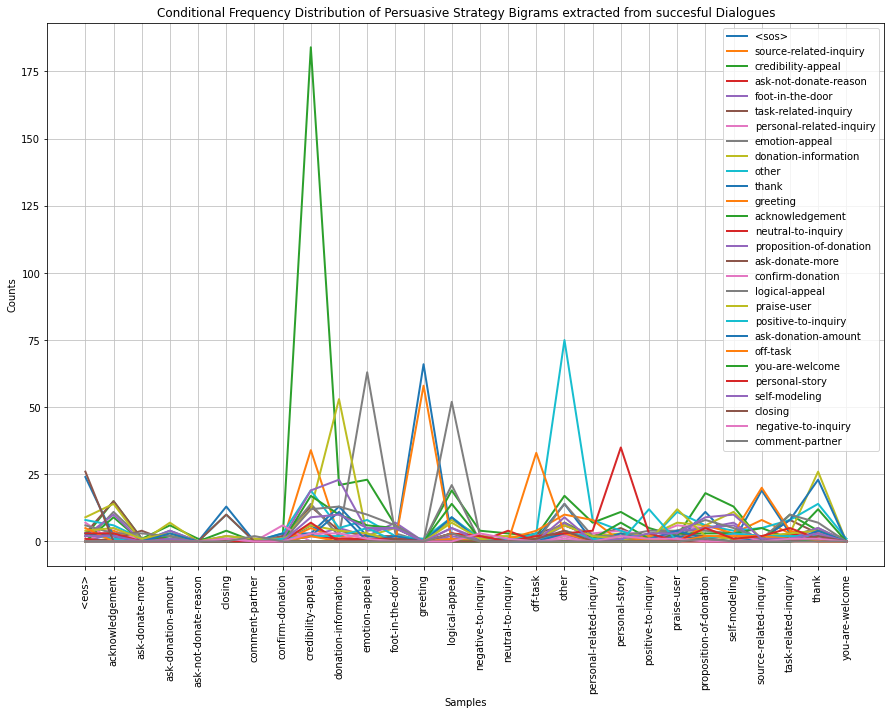

<Figure size 432x288 with 0 Axes>

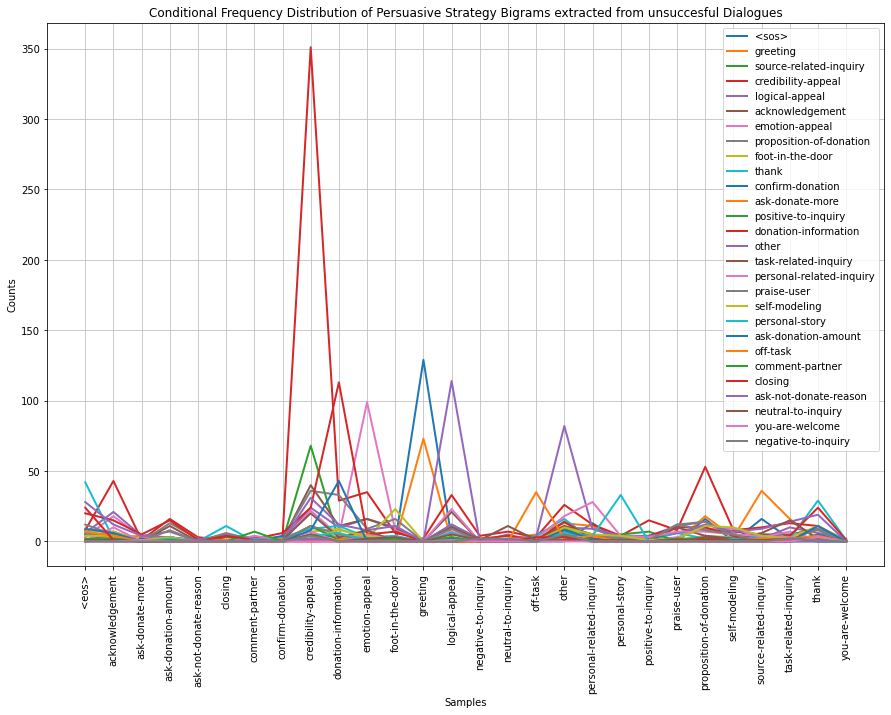

<Figure size 432x288 with 0 Axes>

In [14]:
pos_bigrams = gen_bigrams_list(pos_corpus)
cfd_pos_bi = nltk.ConditionalFreqDist(pos_bigrams)
plot_cfd(cfd_pos_bi, "Conditional Frequency Distribution of Persuasive Strategy Bigrams extracted from succesful Dialogues")

neg_bigrams = gen_bigrams_list(neg_corpus)
cfd_neg_bi = nltk.ConditionalFreqDist(neg_bigrams)
plot_cfd(cfd_neg_bi, "Conditional Frequency Distribution of Persuasive Strategy Bigrams extracted from unsuccesful Dialogues")

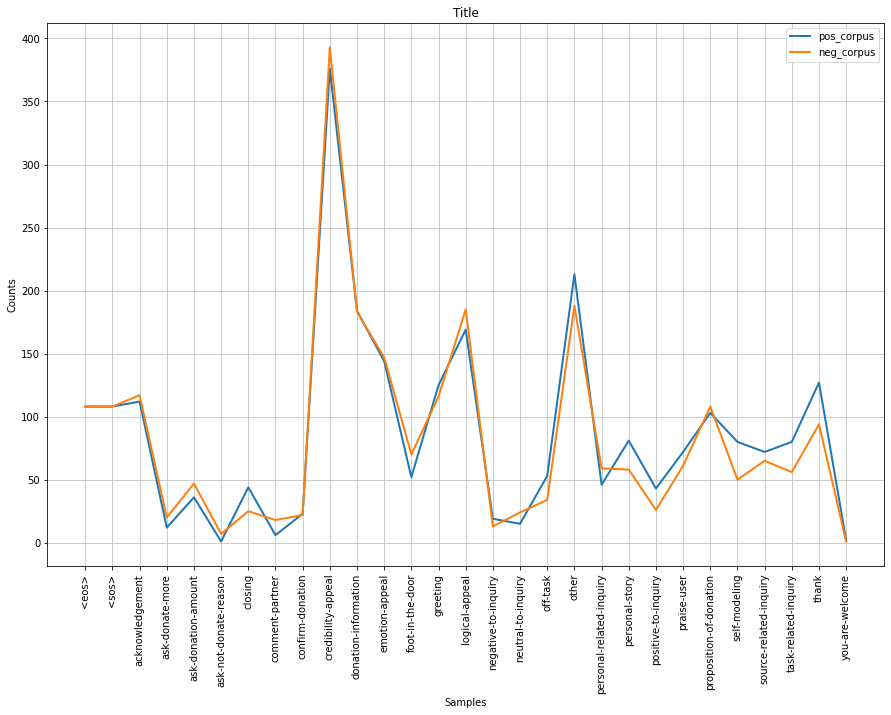

<Figure size 432x288 with 0 Axes>

In [37]:

corpora = [pos_corpus, neg_corpus]
count_list = gen_count_list(corpora)

cfd_count = nltk.ConditionalFreqDist(count_list)

plot_cfd(cfd_count, "Title")


In [51]:
cfd_count.conditions()

cfd_count.tabulate()


                              <eos>                    <sos>          acknowledgement          ask-donate-more      ask-donation-amount    ask-not-donate-reason                  closing          comment-partner         confirm-donation       credibility-appeal     donation-information           emotion-appeal         foot-in-the-door                 greeting           logical-appeal      negative-to-inquiry       neutral-to-inquiry                 off-task                    other personal-related-inquiry           personal-story      positive-to-inquiry              praise-user  proposition-of-donation            self-modeling   source-related-inquiry     task-related-inquiry                    thank          you-are-welcome 
neg_corpus                      108                      108                      117                       20                       47                        7                       25                       18                       22                      393   

## Statistical Analysis

In [54]:
samples = []
for corpus, sample in count_list:
    if sample not in samples:
        samples.append(sample)

print(samples)

['<sos>', 'greeting', 'self-modeling', 'proposition-of-donation', 'emotion-appeal', 'logical-appeal', 'foot-in-the-door', 'confirm-donation', 'other', '<eos>', 'personal-related-inquiry', 'credibility-appeal', 'personal-story', 'source-related-inquiry', 'donation-information', 'off-task', 'closing', 'task-related-inquiry', 'ask-donation-amount', 'praise-user', 'thank', 'acknowledgement', 'negative-to-inquiry', 'neutral-to-inquiry', 'positive-to-inquiry', 'ask-donate-more', 'you-are-welcome', 'comment-partner', 'ask-not-donate-reason']


In [63]:
neg_great = []
pos_great = []

for sample in sorted(samples):
    c_1_count = cfd_count[var_name(corpora[0])][sample]
    c_2_count = cfd_count[var_name(corpora[1])][sample]
    if c_1_count >= c_2_count:
        great_name = var_name(corpora[0])
        great = c_1_count-c_2_count
        pos_great.append(sample)
    else:
        great_name = var_name(corpora[1])
        great = c_2_count - c_1_count
        neg_great.append(sample)

    sample_str = f'''{sample}: 
    {var_name(corpora[0])} - {c_1_count}
    {var_name(corpora[1])} - {c_2_count}
    {great_name} is larger by {great}
    '''
    # print(sample_str)

print(neg_great, pos_great)

['acknowledgement', 'ask-donate-more', 'ask-donation-amount', 'ask-not-donate-reason', 'comment-partner', 'credibility-appeal', 'emotion-appeal', 'foot-in-the-door', 'logical-appeal', 'neutral-to-inquiry', 'personal-related-inquiry', 'proposition-of-donation'] ['<eos>', '<sos>', 'closing', 'confirm-donation', 'donation-information', 'greeting', 'negative-to-inquiry', 'off-task', 'other', 'personal-story', 'positive-to-inquiry', 'praise-user', 'self-modeling', 'source-related-inquiry', 'task-related-inquiry', 'thank', 'you-are-welcome']


## Conclusion